# Calculating NDVI from Phenocam imagery
# Francisco M. Sánchez

# Created: 6/23/2017
# Last modified: 6/23/2017


# Steps:
#### 1. Download the RAW data from https://phenocam.sr.unh.edu/webcam/network/download/
<img src="Sample/phenocamPage.png">

# The images (IR + RGB) are provided every 30 minutes. The download is composed by 2 folders, each one with 336 images.

# How can we obtain the NDVI value from the pair IR + RGB?

In [65]:
import numpy as np
import gdal
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from skimage.filters import gaussian

# Processing of Infrared image

# <img src="Sample/cperuvb_IR_2016_06_21_083005.jpg">

## Conversion from JPG to TIFF

In [66]:
from PIL import Image
im = Image.open('Sample/cperuvb_IR_2016_06_21_083005.jpg')
im.save('IR.tiff')
#plt.show(im)

## Open the TIFF with GDAL

In [67]:
chm_filename = 'Sample/IR.tiff'
chm_dataset = gdal.Open(chm_filename)

### Convert this information into a spatial extent (xMin, xMax, yMin, yMax)

In [85]:
chm_mapinfo = chm_dataset.GetGeoTransform()
xMin = chm_mapinfo[0]
yMax = chm_mapinfo[3]

xMax = xMin + chm_dataset.RasterXSize/chm_mapinfo[1] #divide by pixel width 
yMin = yMax + chm_dataset.RasterYSize/chm_mapinfo[5] #divide by pixel height (note sign +/-)
chm_ext = (xMin,xMax,yMin,yMax)
#noDataVal = chm_raster.GetNoDataValue(); print('no data value:',noDataVal)
scaleFactor = 1.0
print('Raster extent:',chm_ext)

Raster extent: (0.0, 1296.0, 960.0, 0.0)


## Display the dataset dimensions and number of bands

In [86]:
cols = chm_dataset.RasterXSize; print('# of columns:',cols)
rows = chm_dataset.RasterYSize; print('# of rows:',rows)
print('# of bands:',chm_dataset.RasterCount)
print('driver:',chm_dataset.GetDriver().LongName)

# of columns: 1296
# of rows: 960
# of bands: 3
driver: GeoTIFF


# Why 3 Bands?


# <img src="Sample/cperuvb_IR_2016_06_21_083005.jpg">

# We have to avoid the metada displayed on the top... how?

## 1. Read as array every band

### Band 1 IR


In [70]:
chm_array_1 = chm_dataset.GetRasterBand(1).ReadAsArray(0,0,cols,rows).astype(np.float)
chm_array_1=chm_array_1/scaleFactor
chm_array_1=chm_array_1[80:rows,:]
print('Array:\n',chm_array_1) #display array values


Array:
 [[  55.   53.   56. ...,  136.  144.  136.]
 [  59.   56.   58. ...,  130.  139.  132.]
 [  60.   56.   59. ...,  127.  137.  131.]
 ..., 
 [  13.   22.   32. ...,   42.   26.    4.]
 [  33.   31.   11. ...,   45.    8.   33.]
 [  46.   46.   55. ...,   51.   43.   41.]]


### Band 2 IR

In [71]:
chm_array_2 = chm_dataset.GetRasterBand(2).ReadAsArray(0,0,cols,rows).astype(np.float)
chm_array_2=chm_array_2/scaleFactor
chm_array_2=chm_array_2[97:rows,:]
print('Array:\n',chm_array_2) #display array values

Array:
 [[ 115.  127.  115. ...,  103.  108.  123.]
 [ 109.  128.  121. ...,  104.  105.  120.]
 [ 104.  118.  120. ...,  118.  118.  115.]
 ..., 
 [  13.   22.   32. ...,   42.   26.    4.]
 [  33.   31.   11. ...,   45.    8.   33.]
 [  46.   46.   55. ...,   51.   43.   41.]]


### Band 3 IR

In [72]:
chm_array_3 = chm_dataset.GetRasterBand(3).ReadAsArray(0,0,cols,rows).astype(np.float)
chm_array_3=chm_array_3/scaleFactor
chm_array_3=chm_array_3[97:rows,:]
print('Array:\n',chm_array_3) #display array values

Array:
 [[ 115.  127.  115. ...,  103.  108.  123.]
 [ 109.  128.  121. ...,  104.  105.  120.]
 [ 104.  118.  120. ...,  118.  118.  115.]
 ..., 
 [  13.   22.   32. ...,   42.   26.    4.]
 [  33.   31.   11. ...,   45.    8.   33.]
 [  46.   46.   55. ...,   51.   43.   41.]]


# From raw number 97 all the values are equals! Correct Submatrix found!

## 2. Plot the band

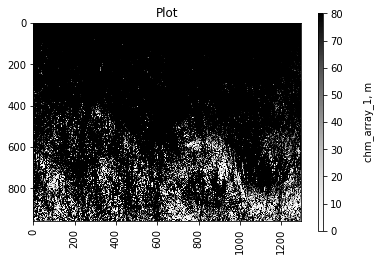

In [73]:
# Define the plot_band_array function
def plot_band_array(band_array,refl_extent,colorlimit,ax=plt.gca(),title='',cbar ='on',cmap_title='',colormap='Greys'):
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90); #rotate x tick labels 90 degrees

plot_band_array(chm_array_2,chm_ext,(0,80),title='Plot',cmap_title='chm_array_1, m')

# 3. Clean noise with Gaussian function

In [74]:
array_ir_smooth = gaussian(chm_array_2,3)

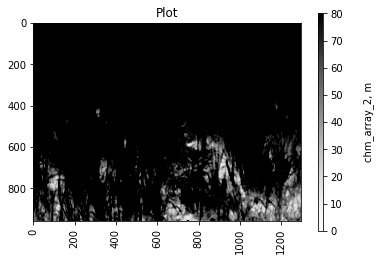

In [75]:
plot_band_array(array_ir_smooth,chm_ext,(0,80),title='Plot',cmap_title='chm_array_2, m')

# Processing of RGB image

# <img src="Sample/cperuvb_2016_06_21_083005.jpg">

## Conversion from JPG to TIFF

In [76]:
im = Image.open('Sample/cperuvb_2016_06_21_083005.jpg')
im.save('NoIR.tiff')


## Open the TIFF with GDAL

In [77]:
chm_filename2 = 'Sample/NoIR.tiff'
chm_dataset2 = gdal.Open(chm_filename2)

## Display the dataset dimensions and number of bands

In [78]:
cols = chm_dataset2.RasterXSize; print('# of columns:',cols)
rows = chm_dataset2.RasterYSize; print('# of rows:',rows)
print('# of bands:',chm_dataset2.RasterCount)
print('driver:',chm_dataset2.GetDriver().LongName)

# of columns: 1296
# of rows: 960
# of bands: 3
driver: GeoTIFF


## 1. Read as array every band
## Red Band

Array:
 [[  55.   53.   56. ...,  136.  144.  136.]
 [  59.   56.   58. ...,  130.  139.  132.]
 [  60.   56.   59. ...,  127.  137.  131.]
 ..., 
 [  13.   22.   32. ...,   42.   26.    4.]
 [  33.   31.   11. ...,   45.    8.   33.]
 [  46.   46.   55. ...,   51.   43.   41.]]


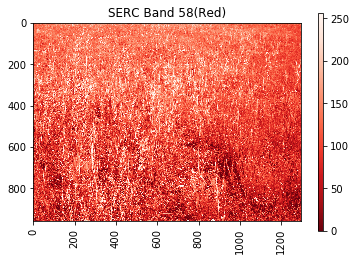

In [79]:
chm_array_10 = chm_dataset2.GetRasterBand(1).ReadAsArray(0,0,cols,rows).astype(np.float)
#### chm_array[chm_array==int(noDataVal)]=np.nan #Assign CHM No Data Values to NaN
chm_array_10=chm_array_10/scaleFactor
chm_array_10=chm_array_10[97:rows,:]
print('Array:\n',chm_array_1) #display array values

colorlimit = (0,256) # set color from 0-256

plot_band_array(chm_array_10,chm_ext,colorlimit,title='SERC Band 58(Red)',colormap='Reds_r')

## Green Band

Array:
 [[ 115.  127.  115. ...,  103.  108.  123.]
 [ 109.  128.  121. ...,  104.  105.  120.]
 [ 104.  118.  120. ...,  118.  118.  115.]
 ..., 
 [  13.   22.   32. ...,   42.   26.    4.]
 [  33.   31.   11. ...,   45.    8.   33.]
 [  46.   46.   55. ...,   51.   43.   41.]]


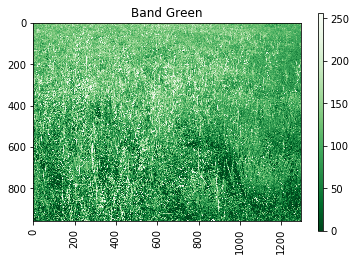

In [80]:
chm_array_20 = chm_dataset2.GetRasterBand(2).ReadAsArray(0,0,cols,rows).astype(np.float)
#### chm_array[chm_array==int(noDataVal)]=np.nan #Assign CHM No Data Values to NaN
chm_array_20=chm_array_20/scaleFactor
chm_array_20=chm_array_20[97:rows,:]
print('Array:\n',chm_array_2) #display array values
plot_band_array(chm_array_20,chm_ext,colorlimit,title='Band Green',colormap='Greens_r')

## Blue Band

Array:
 [[ 115.  127.  115. ...,  103.  108.  123.]
 [ 109.  128.  121. ...,  104.  105.  120.]
 [ 104.  118.  120. ...,  118.  118.  115.]
 ..., 
 [  13.   22.   32. ...,   42.   26.    4.]
 [  33.   31.   11. ...,   45.    8.   33.]
 [  46.   46.   55. ...,   51.   43.   41.]]


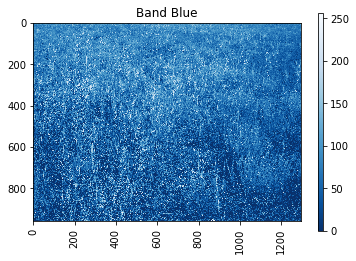

In [81]:
chm_array_30 = chm_dataset2.GetRasterBand(3).ReadAsArray(0,0,cols,rows).astype(np.float)
#### chm_array[chm_array==int(noDataVal)]=np.nan #Assign CHM No Data Values to NaN
chm_array_30=chm_array_30/scaleFactor
chm_array_30=chm_array_30[97:rows,:]
print('Array:\n',chm_array_3) #display array values
plot_band_array(chm_array_30,chm_ext,colorlimit,title='Band Blue',colormap='Blues_r')

## Clean noise with Gaussian function

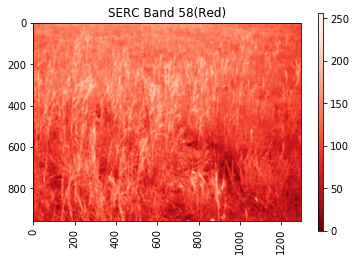

In [82]:
# Blur the array in order to avoid the noise
array_vis_smooth = gaussian(chm_array_10,3)
plot_band_array(array_vis_smooth,chm_ext,colorlimit,title='SERC Band 58(Red)',colormap='Reds_r')

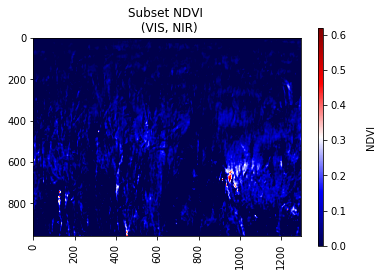

In [83]:
import pylab
vis = array_vis_smooth.astype(float)
nir = array_ir_smooth.astype(float) 

ndvi = np.divide((nir-vis),(nir+vis))
plot_band_array(ndvi,chm_ext,(0,np.max(ndvi)),title='Subset NDVI \n (VIS, NIR)',cmap_title='NDVI',colormap='seismic')
pylab.savefig('Sample/NDVIsample.png')

In [84]:
ndvi_valor = np.nanmean(ndvi,dtype=np.float64)
print (ndvi_valor)


-0.0118804734859


# NDVI value: -0.0118804734859